# Regressão de curva  logística
A modelagem da progressão de doenças pode ser feita de várias maneiras, mas a maioria delas tem uma curva logística como resultado. Essa curva pode ser regredida a partir dos dados da progressão atual e da função logística, caracterizada por
$$
Q(t)=\frac{K}{1+a\exp(-bt)}
$$
onde $K$ pode ser considerado o limite superior de número de casos, $a$ é uma constante, $b$ é a taxa de incubação da doença, e $t$ é o tempo passado até o momento em dias.

O objetivo desse notebook é conseguir estimar os parâmetros $a$, $b$ e $K$ do crescimento do COVID-19 em um país a partir dos dados socioeconômicos do prório.

Em um primeiro momento, vamos regredir a curva logística do país utilizando os dados da progressão de sua doença e a função `curve_fit` do `scipy`, que regride uma curva a partir de Quadrados Mínimos não lineares.

A partir dos parâmetros obtidos, utilizaremos esses como o alvo de uma nova regressão, dessa vez a partir dos dados socioeconômicos dos países. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import curve_fit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

Para utilizarmos a função `curve_fit`, precisamos definir a função que queremos regredir em `python`, o que está feito abaixo.

In [2]:
def logistic_curve(t, a, b, K):
    return K / (1 + a * np.exp(-b*t))

Em seguida, lemos os dados dos países, tanto de progressão do COVID-19, tanto os dados socioeconômicos e geográficos do país.

In [3]:
df_covid = pd.read_csv('../databases/worldCovid_v2.csv',index_col=0)
df_info = pd.read_csv('../databases/worldInfo_v2.csv',index_col=0)

In [4]:
df_info

,Country,IDH,GNI_per_capita,pop_total,densidade_pop,pop_idade,pop_urbana,chegada_turistas,gasto_saude_per_capita,acesso_agua,temp_media,area_floresta,precipitacao
0,NORWAY,0.95,68058.62,5421241.0,15.0,40.0,0.83,5688000.0,7936.38,1.00,1.50,0.33,1414.0
1,SWITZERLAND,0.95,59374.73,8654622.0,219.0,43.0,0.74,10362000.0,9956.26,1.00,5.50,0.32,1537.0
2,IRELAND,0.94,55659.68,4937786.0,72.0,38.0,0.63,10926000.0,4976.86,0.98,9.30,0.11,1118.0
3,GERMANY,0.94,46945.95,83783942.0,240.0,46.0,0.76,38881000.0,5033.45,1.00,8.50,0.33,700.0
4,AUSTRALIA,0.94,44097.02,25499884.0,3.0,38.0,0.86,9246000.0,5331.82,1.00,21.65,0.16,534.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,MOZAMBIQUE,0.45,1153.70,31255435.0,40.0,18.0,0.38,2743000.0,21.07,0.81,23.80,0.48,1032.0
112,SIERRA LEONE,0.44,1381.30,7976983.0,111.0,19.0,0.43,57000.0,66.40,0.85,26.05,0.43,2526.0
113,BURKINA FASO,0.43,1705.49,20903273.0,76.0,18.0,0.31,144000.0,44.40,0.98,28.25,0.19,748.0
114,MALI,0.43,1965.39,20250833.0,17.0,16.0,0.44,14000.0,31.38,0.96,28.25,0.04,282.0


In [5]:
df_covid[df_covid['Cumulative_cases'] > 0]

,Date_reported,Country,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
53,2020-02-25,ALGERIA,5,5,0,0
54,2020-02-26,ALGERIA,0,5,0,0
55,2020-02-27,ALGERIA,0,5,0,0
56,2020-02-28,ALGERIA,0,5,0,0
57,2020-02-29,ALGERIA,0,5,0,0
...,...,...,...,...,...,...
34331,2020-10-20,ZIMBABWE,12,8159,1,232
34332,2020-10-21,ZIMBABWE,28,8187,1,233
34333,2020-10-22,ZIMBABWE,28,8215,3,236
34334,2020-10-23,ZIMBABWE,27,8242,0,236


## Prova de conceito e regressão inicial
Aplicamos a regressão baseada no `curve_fit` apenas em um país como prova de conceito.

In [6]:
df_regression = df_covid[df_covid['Country'] == 'ALGERIA']
df_regression.reset_index(inplace=True, drop=True)
df_regression

,Date_reported,Country,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-03,ALGERIA,0,0,0,0
1,2020-01-04,ALGERIA,0,0,0,0
2,2020-01-05,ALGERIA,0,0,0,0
3,2020-01-06,ALGERIA,0,0,0,0
4,2020-01-07,ALGERIA,0,0,0,0
...,...,...,...,...,...,...
291,2020-10-20,ALGERIA,214,54616,9,1865
292,2020-10-21,ALGERIA,223,54839,8,1873
293,2020-10-22,ALGERIA,252,55091,7,1880
294,2020-10-23,ALGERIA,266,55357,8,1888


In [7]:
(a, b, K), cov = curve_fit(logistic_curve,df_regression.index, df_regression['Cumulative_cases'].values)
print(a)
print(b)
print(K)

874.1833776849737
0.032244956635101456
59053.57448687641


In [8]:
X = df_regression.index
y_true = df_regression['Cumulative_cases']
y_pred = logistic_curve(X, a, b, K)
print("R2 Score:", r2_score(y_true, y_pred))

R2 Score: 0.9971845771937398


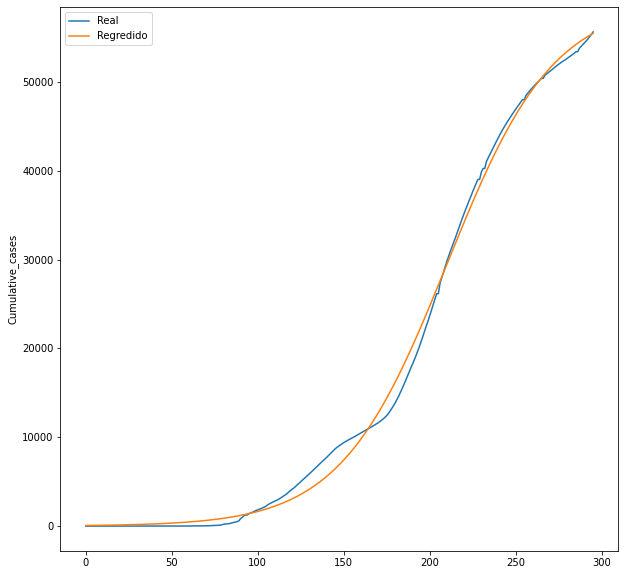

In [9]:
_, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(x=X, y=y_true, label='Real', ax=ax)
sns.lineplot(x=X, y=y_pred, label='Regredido', ax=ax)
plt.show()

Como podemos ver pelo gráfico acima, a curva logística é uma boa aproximação para a progressão da doença nesse país. Esse é também o caso para quase todos os países na base de dados.

## Curvas logísticas para todos os países

In [10]:
from sklearn.metrics import r2_score

In [11]:
paises = df_covid['Country'].unique()

Para fazer a regressão de todos os países, partimos do pressuposto de que o limite superior de $K$ é a população total do país, e o limite de $b$ é a taxa de transmissão do COVID, que foi estimada a ser entre 2 e 3.

In [12]:
var_logisticas = {}
scores = 0
for pais in paises:
  pop_pais = df_info[df_info['Country'] == pais]['pop_total'].item()
  bounds = (0, [10e5,3., pop_pais ])
  df_regression = df_covid[(df_covid['Country'] == pais) & (df_covid['Cumulative_cases'] > 0)]
  df_regression.reset_index(inplace=True, drop=True) # resetando o index para t = [0, D]
  (a, b, K), cov = curve_fit(logistic_curve,
                            df_regression.index,
                            df_regression['Cumulative_cases'].values,
                            maxfev=5000,
                            bounds=bounds)
  
  scores += r2_score(df_regression['Cumulative_cases'].values, logistic_curve(df_regression.index, a, b, K))
  var_logisticas[pais] = (a, b, K)
print("R2 médio:", scores/len(paises))


R2 médio: 0.958379707343154


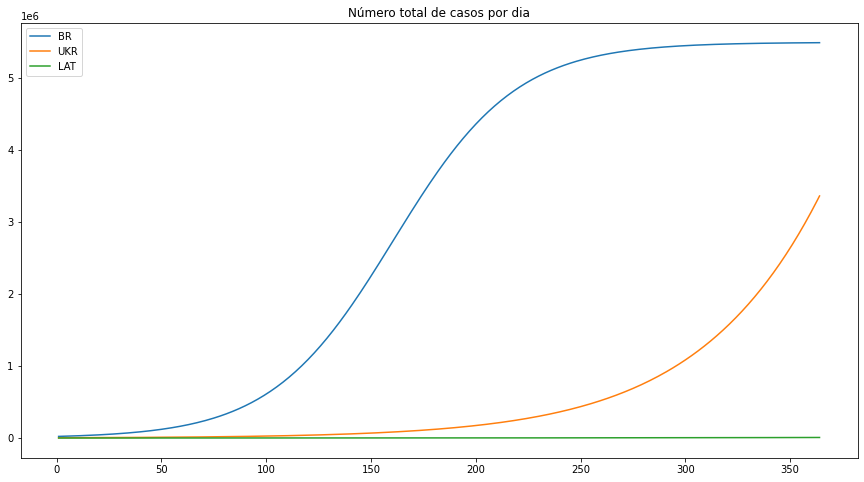

In [13]:
_, ax = plt.subplots(figsize=(15, 8))
# 3-tupla formada por (a, b, K)
contagio1 = []
contagio2 = []
contagio3 = []
uk = var_logisticas['UNITED KINGDOM']
eua = var_logisticas['UNITED STATES']
ukr = var_logisticas['UKRAINE']
br = var_logisticas['BRAZIL']
lat = var_logisticas['LATVIA']
t= np.array(range(1, 365))
contagio1 =logistic_curve(t, *br)
contagio2 =logistic_curve(t, *ukr)
contagio3 =logistic_curve(t, lat[0], lat[1], lat[2])

# fig, ax = plt.subplots(1,2)
sns.lineplot(ax=ax,x=t, y=contagio1, label='BR')
sns.lineplot(ax=ax,x=t, y=contagio2, label='UKR')
sns.lineplot(ax=ax,x=t, y=contagio3, label='LAT')
plt.title('Número total de casos por dia')
plt.legend()
plt.show()

Podemos estimar o número diários de casos a partir da curva calculando a "derivada" da mesma, estimando os dias seguintes e subtraindo dos anteriores.

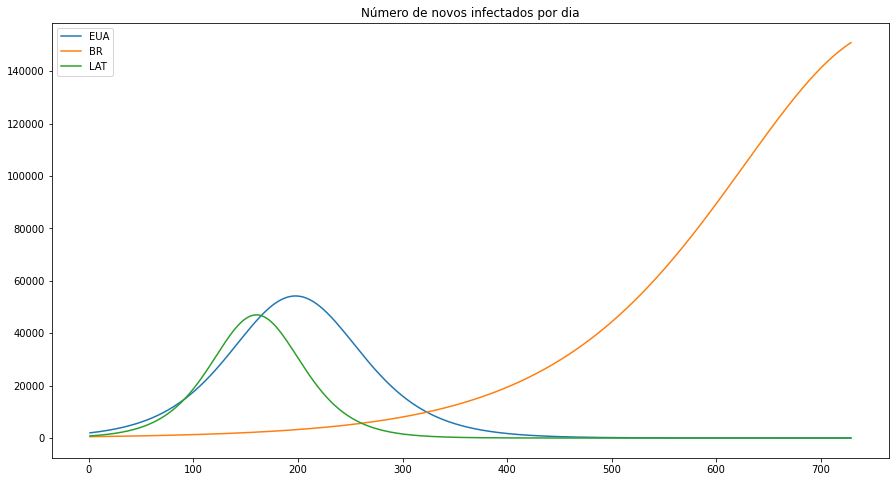

In [14]:
_, ax = plt.subplots(figsize=(15, 8))
x1 = range(1,365*2)
x2 = range(2,365*2 + 1)
y1 = logistic_curve(x1, *eua)
y2 = logistic_curve(x2, *eua)
sns.lineplot(ax=ax,x=x1, y=y2-y1, label='EUA')
y1 = logistic_curve(x1, *uk)
y2 = logistic_curve(x2, *uk)
sns.lineplot(ax=ax,x=x1, y=y2-y1, label='BR')
y1 = logistic_curve(x1, *br)
y2 = logistic_curve(x2, *br)
sns.lineplot(ax=ax,x=x1, y=y2-y1, label='LAT')
plt.title('Número de novos infectados por dia')
plt.show()

Apesar de bem compatível com a maioria dos países, algumas curvas não condizem com a realidade, podemos ver isso, por exemplo, na curva da Austrália e no Reino Unido, que, devido às medidas mitigadoras (como o isolamento) possuem comportamentos peculiares.

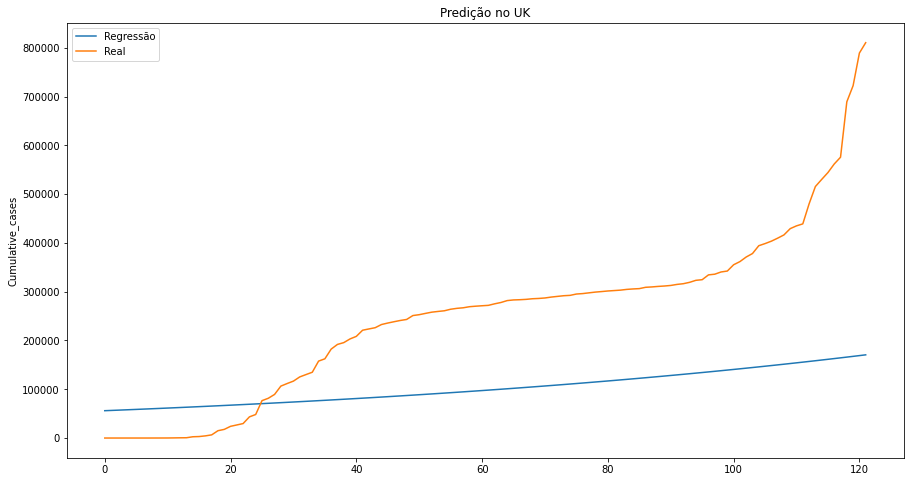

In [15]:
_, ax = plt.subplots(figsize=(15, 8))
plt.title("Predição no UK")
uk = var_logisticas['UNITED KINGDOM']
y_true = df_covid[(df_covid['Country'] == 'UNITED KINGDOM') & df_covid['Cumulative_cases'] >0]['Cumulative_cases']
t = np.arange(len(y_true))
contagio1 =logistic_curve(t, *uk)
sns.lineplot(ax=ax,x=t, y=contagio1, label='Regressão')
sns.lineplot(ax=ax,x=t, y=y_true, label='Real')
plt.show()


## Estimando os parâmetros da curva logística a partir de dados socioeconômicos
Após concluir que a curva logística é, em maioria, uma boa aproximação para a curva real da doença, queremos saber se é possível estimar os mesmos parâmetros, ($K$, $a$ e $b$), a partir dos dados socioeconômicos do país.

Depois dos valores de regressão conseguidos pelo `curve_fit`, utilizamos os mesmos como o alvo da predição de um regressor [`xgboost`](https://en.wikipedia.org/wiki/XGBoost). Como o alvo da regressão são três valores ($K$, $a$ e $b$), utilizamos um *wrapper* implementado pelo `sklearn` chamado [`MultiOutputRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputRegressor.html).

In [16]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler

Como entrada para o regressor, z-normalizamos os valores do *dataframe* contendo os valores geográficos e socioeconômicos de cada país e o atribuímos ao $X$. Para o $y$, utilizamos as regressões feitas anteriormente. 

In [18]:
X = StandardScaler().fit_transform(pd.read_csv("../databases/worldInfo_v2.csv").values[:, 2:])
y = np.array(list(var_logisticas.values()))

Como prova de conceito, treinamos um regressor com uma complexidade imensa, para fazer o *overfit* dos dados e testar se o modelo funciona.

In [19]:
mor = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror', max_depth=10000)).fit(X, y)

/home/doc/workdir/tp-icd/.venv/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [20]:
r2_score(y, mor.predict(X))

0.99991832311597

Como o score R2 do regressor foi muito próximo de 1, o modelo consegue extrair informação o suficiente para prever os valores.


Depois da prova de conceito, fizemos uma validação cruzada utilizando um `kfold` de 5 folds, com o método [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). 

Os híperparâmetros principais em questão são o `eta`, que é a taxa de aprendizado do algoritmo, o `max_depth`, que significa a profundidade máxima de cada árvore do algoritmo de *boosting*, e o `n_estimator`, que é o número de estimadores no *boosting*.

O hiperparâmetro `booster` é o tipo de modelo simples utilizado na predição, sendo o mais comum a árvore.

In [21]:
eta = [1e-10, 1e-7, 1e-4,1e-3]
max_depth = [ 8, 16, 32]
n_estimators = [10, 20, 30, 40, 50]
booster = ['gbtree', 'gblinear' , 'dart']

In [22]:
params = {"estimator__eta": eta,
          "estimator__max_depth": max_depth,
          "estimator__n_estimators": n_estimators,
}
xgbst = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror', alpha=1))
model = GridSearchCV(xgbst, params, cv=5)

In [23]:
multioutputregressor = model.fit(X, y)

/home/doc/workdir/tp-icd/.venv/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/home/doc/workdir/tp-icd/.venv/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/home/doc/workdir/tp-icd/.venv/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/home/doc/workdir/tp-icd/.venv/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will 

/home/doc/workdir/tp-icd/.venv/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/home/doc/workdir/tp-icd/.venv/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/home/doc/workdir/tp-icd/.venv/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/home/doc/workdir/tp-icd/.venv/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will 

/home/doc/workdir/tp-icd/.venv/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/home/doc/workdir/tp-icd/.venv/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/home/doc/workdir/tp-icd/.venv/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/home/doc/workdir/tp-icd/.venv/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will 

/home/doc/workdir/tp-icd/.venv/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/home/doc/workdir/tp-icd/.venv/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/home/doc/workdir/tp-icd/.venv/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/home/doc/workdir/tp-icd/.venv/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will 

/home/doc/workdir/tp-icd/.venv/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/home/doc/workdir/tp-icd/.venv/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/home/doc/workdir/tp-icd/.venv/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/home/doc/workdir/tp-icd/.venv/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will 

/home/doc/workdir/tp-icd/.venv/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/home/doc/workdir/tp-icd/.venv/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/home/doc/workdir/tp-icd/.venv/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/home/doc/workdir/tp-icd/.venv/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will 

/home/doc/workdir/tp-icd/.venv/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/home/doc/workdir/tp-icd/.venv/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/home/doc/workdir/tp-icd/.venv/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/home/doc/workdir/tp-icd/.venv/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will 

/home/doc/workdir/tp-icd/.venv/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/home/doc/workdir/tp-icd/.venv/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/home/doc/workdir/tp-icd/.venv/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/home/doc/workdir/tp-icd/.venv/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will 

/home/doc/workdir/tp-icd/.venv/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/home/doc/workdir/tp-icd/.venv/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/home/doc/workdir/tp-icd/.venv/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/home/doc/workdir/tp-icd/.venv/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will 

Depois de treinado, podemos perceber que o melhor regressor tem um `score` baixo, de -1. Isso era esperado, dado o *dataset* pequeno. 

In [24]:
print(multioutputregressor.best_params_)
print(multioutputregressor.best_score_)


{'estimator__eta': 0.001, 'estimator__max_depth': 8, 'estimator__n_estimators': 50}
-79.65076803986742


Conseguimos visualizar o resultado da regressão em cada país com o método abaixo.

In [25]:
def plot_e_score_pais(pais):
  _, ax = plt.subplots(figsize=(15, 8))
  index = list(var_logisticas.keys()).index(pais)
  X_local = X[index].reshape(1, -1)
  y_true =  df_covid[(df_covid['Country'] == pais) & (df_covid['Cumulative_cases'] > 0)]['Cumulative_cases'].values
  x = np.arange(len(y_true))
  x_reg = multioutputregressor.predict(X_local)[0]
  x_ovf = mor.predict(X_local)[0]
  y_xgb = logistic_curve(x, *x_reg)
  y_ovf = logistic_curve(x, *x_ovf)
  y_reg = logistic_curve(x, *var_logisticas[pais])
  sns.lineplot(ax=ax,x=x, y=y_true, label='Valor real')
  sns.lineplot(ax=ax,x=x, y=y_reg, label='Valor regressão logística')
  sns.lineplot(ax=ax,x=x, y=y_xgb, label='Valor regressão xgboost')
  sns.lineplot(ax=ax,x=x, y=y_ovf, label='Valor regressão xgboost overfitada')
  plt.show()
  print('R2 com relacao ao real:', r2_score(y_true, y_xgb))
  print('R2 com relacao à regressão:', r2_score(y_reg, y_xgb))
  print('R2 overfitado com relacao ao real:', r2_score(y_true, y_ovf))
  print('R2 overfitado com relacao à regressão:', r2_score(y_reg, y_ovf))

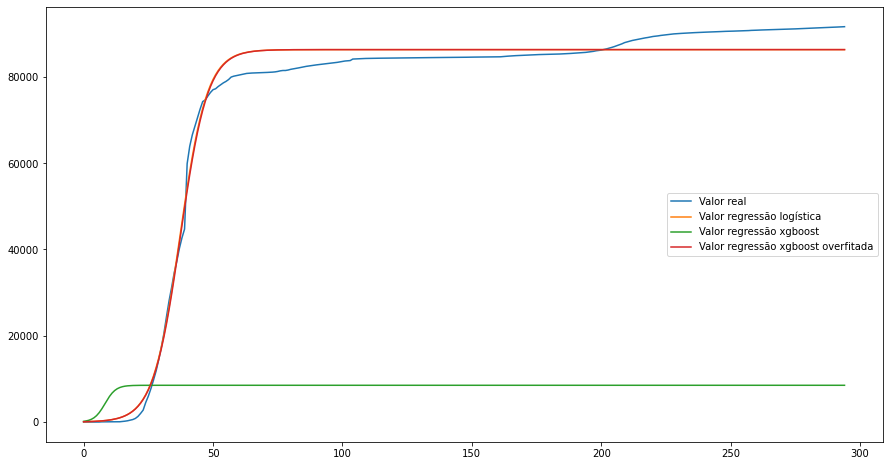

R2 com relacao ao real: -6.154395953353672
R2 com relacao à regressão: -6.369617857351265
R2 overfitado com relacao ao real: 0.9860243681238436
R2 overfitado com relacao à regressão: 0.9999591013053787


In [26]:
plot_e_score_pais('CHINA')

## Conclusão
Apesar da ideia de associar os dados socioeconômicos com a progressão do COVID-19 ser interessante, os resultados mostram que o modelo treinado com esses dados não é suficientemente bom para prever o total de casos para vários países. Isso se deve a alguns fatores, como o crescimento ainda em andamento da curva, a baixa quantidade de dados disponíveis para análise e o comportamento inesperado de alguns países.